<a href="https://colab.research.google.com/github/Carlo-Cascini/Carlo-Cascini/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Once we know what are the pairs of stocks that we will have to trade in a particular year, we have to backtest this results

To trade the pairs we will compare 4 methods to compute the spread:
1) least squares regression (with all available datas
2) rolling least square regression (rolling window has to be selected)
3) kalman filter estimation of alfa and beta
4) beta estimation of the spread with partial_CI (ci soffermiamo dopo)

pacchetti necessari

In [8]:
# Check if the 'quantmod', 'xts', 'zoo', and 'KFAS' packages are installed, and install them if not
required_packages <- c("quantmod", "xts", "zoo", "KFAS")
new_packages <- required_packages[!(required_packages %in% installed.packages()[,"Package"])]
if(length(new_packages)) install.packages(new_packages)
library(quantmod)
library(xts)
library(zoo)
library(TTR)
library(KFAS)


Please cite KFAS in publications by using: 

  Jouni Helske (2017). KFAS: Exponential Family State Space Models in R. Journal of Statistical Software, 78(10), 1-39. doi:10.18637/jss.v078.i10.



CARICAMENTO DATI

In [26]:
library(quantmod)
library(xts)
library(TTR)

# Define the date range and stock list
begin_date <- "2000-01-01"
end_date <- "2023-12-31"
stock_namelist <- c("EWA", "EWK", "EWO", "EWC", "EWQ", "EWG", "EWH",
                    "EWI", "EWJ", "EWM", "EWW", "EWN", "EWS", "EWP",
                    "EWD", "EWL", "EWY", "EZU", "EWU", "EWZ", "EWT",
                    "SPY", "EZA", "EPI", "RSX", "TUR", "KSA", "GREK",
                    "EIS", "ARGT", "THD", "PIN", "NORW", "IEUR", "EEM",
                    "VWO", "AAXJ", "ILF", "AFK", "FEZ", "XLF", "XLK",
                    "XLE", "XLV", "XLY", "XLI", "XLB", "XLU", "IYR",
                    "SMH", "XBI", "VTI", "VOO", "IVV", "QQQ", "IWV",
                    "GLD", "SLV", "PPLT", "PALL", "USO", "BNO", "UNG",
                    "DBO", "DBC", "CORN", "SOYB", "WEAT", "COW", "JJG",
                    "UGA", "OIL", "DBA", "GSG", "COMT", "RJI", "FTGC",
                    "BCI")

# Download data from Yahoo Finance
prices <- xts()
for (stock_index in 1:length(stock_namelist)) {
  stock_data <- Ad(getSymbols(stock_namelist[stock_index],
                              from = begin_date, to = end_date, auto.assign = FALSE))
  prices <- cbind(prices, stock_data)
}
colnames(prices) <- stock_namelist
indexClass(prices) <- "Date"

# Log-prices
Y <- log(prices)

Warning message:
“COW contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“JJG contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“OIL contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“RJI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message in `indexClass<-`(`*tmp*`, value = "Date"):
“'indexClass<-' is deprecated.
Use 'tclass<-' instead.
S

In [119]:
estimate_mu_gamma_LS <- function(Y, pct_training = 0.2) {
  T <- nrow(Y)
  T_trn <- round(pct_training*T)
  # LS regression
  ls_coeffs <- coef(lm(Y[1:T_trn, 1] ~ Y[1:T_trn, 2]))
  mu <- xts(rep(ls_coeffs[1], T), index(Y))
  colnames(mu) <- "mu-LS"
  gamma <- xts(rep(ls_coeffs[2], T), index(Y))
  colnames(gamma) <- "gamma-LS"
  return(list(mu = mu, gamma = gamma))
}

estimate_mu_gamma_rolling_LS <- function(Y, pct_training = 0.2) {
  T <- nrow(Y)
  T_start <- round(pct_training*T)
  T_lookback <- 500  # lookback window length
  T_shift <- 10  # how often is refreshed
  # init empty variables
  gamma_rolling_LS <- mu_rolling_LS <- xts(rep(NA, T), index(Y))
  colnames(mu_rolling_LS) <- "mu-rolling-LS"
  colnames(gamma_rolling_LS) <- "gamma-rolling-LS"
  # loop
  t0_update <- seq(from = min(T_start, T_lookback), to = T-T_shift, by = T_shift)
  for (t0 in t0_update) {
    T_lookback_ <- ifelse(t0-T_lookback+1 >= 1, T_lookback, T_start)
    ls_coeffs <- coef(lm(Y[(t0-T_lookback_+1):t0, 1] ~ Y[(t0-T_lookback_+1):t0, 2],
                         weights = last(1:T_lookback, T_lookback_)))
    mu_rolling_LS[t0+1] <- ls_coeffs[1]
    gamma_rolling_LS[t0+1] <- ls_coeffs[2]
  }
  # complete values
  mu_rolling_LS <- na.locf(mu_rolling_LS)
  mu_rolling_LS <- na.locf(mu_rolling_LS, fromLast = TRUE)
  gamma_rolling_LS <- na.locf(gamma_rolling_LS)
  gamma_rolling_LS <- na.locf(gamma_rolling_LS, fromLast = TRUE)
  # smoothing
  L <- 15
  mu_rolling_LS[] <- filter(mu_rolling_LS, rep(1, L)/L, sides = 1)
  mu_rolling_LS <- na.locf(mu_rolling_LS, fromLast = TRUE)
  gamma_rolling_LS[] <- filter(gamma_rolling_LS, rep(1, L)/L, sides = 1)
  gamma_rolling_LS <- na.locf(gamma_rolling_LS, fromLast = TRUE)
  return(list(mu = mu_rolling_LS, gamma = gamma_rolling_LS))
}

estimate_mu_gamma_Kalman <- function(Y) {
  T <- nrow(Y)
  # init empty variables
  gamma_Kalman_filtering <- mu_Kalman_filtering <- xts(rep(NA, T), index(Y))
  colnames(mu_Kalman_filtering) <- "mu-Kalman"
  colnames(gamma_Kalman_filtering) <- "gamma-Kalman"
  # Kalman parameters
  Tt <- diag(2)
  Rt <- diag(2)
  Qt <- 1e-5*diag(2)  # state transition variance very small
  Zt <- array(as.vector(t(cbind(1, as.matrix(Y[, 2])))), dim = c(1, 2, T))  # time-varying
  Ht <- matrix(1e-3)  # observation variance
  # the prior in the code: P1cov = kappa*P1Inf + P1, kappa = 1e7
  init <- estimate_mu_gamma_LS(Y)
  a1 <- matrix(c(init$mu[1], init$gamma[1]), 2, 1)
  P1 <- 1e-5*diag(2)  # variance of initial point
  P1inf <- 0*diag(2)
  # create Kalman model
  model <- SSModel(as.matrix(Y[, 1]) ~ 0 + SSMcustom(Z=Zt, T=Tt, R=Rt, Q=Qt, a1=a1, P1=P1, P1inf=P1inf), H=Ht)
  # run Kalman filtering
  out <- KFS(model)
  mu_Kalman_filtering[] <- out$a[-1, 1]  # a is Kalman filtering (alphahat is Kalman smoothing) (a(T+1)=alphahat(T))
  gamma_Kalman_filtering[] <- out$a[-1, 2]
  # smoothing
  L <- 30
  mu_Kalman_filtering[] <- filter(mu_Kalman_filtering, rep(1, L)/L, sides = 1)
  mu_Kalman_filtering <- na.locf(mu_Kalman_filtering, fromLast = TRUE)
  gamma_Kalman_filtering[] <- filter(gamma_Kalman_filtering, rep(1, L)/L, sides = 1)
  gamma_Kalman_filtering <- na.locf(gamma_Kalman_filtering, fromLast = TRUE)
  return(list(mu = mu_Kalman_filtering, gamma = gamma_Kalman_filtering))
}
# we define a function for convenience and future use
generate_signal <- function(Z_score, threshold_long, threshold_short) {
  signal <- Z_score
  colnames(signal) <- "signal"
  signal[] <- NA

  #initial position
  signal[1] <- 0
  if (Z_score[1] <= threshold_long[1]) {
    signal[1] <- 1
  } else if (Z_score[1] >= threshold_short[1])
    signal[1] <- -1

  # loop
  for (t in 2:nrow(Z_score)) {
    if (signal[t-1] == 0) {  #if we were in no position
      if (Z_score[t] <= threshold_long[t]) {
        signal[t] <- 1
      } else if(Z_score[t] >= threshold_short[t]) {
        signal[t] <- -1
      } else signal[t] <- 0
    } else if (signal[t-1] == 1) {  #if we were in a long position
      if (Z_score[t] >= 0) signal[t] <- 0
      else signal[t] <- signal[t-1]
    } else {  #if we were in a short position
      if (Z_score[t] <= 0) signal[t] <- 0
      else signal[t] <- signal[t-1]
    }
  }
  return(signal)
}


generate_Z_score_EMA <- function(spread, n = 150) {
  ## traditional rolling windowed mean and variance
  # first, the mean
  spread.mean <- EMA(spread, n)
  spread.mean <- na.locf(spread.mean, fromLast = TRUE)
  spread.demeaned <- spread - spread.mean
  # second, the variance
  spread.var <- EMA(spread.demeaned^2, n)
  spread.var <- na.locf(spread.var, fromLast = TRUE)
  # finally compute Z-score
  Z.score <- spread.demeaned/sqrt(spread.var)
  return(Z.score)
}

pairs_trading <- function(Y, gamma, mu, name = NULL, threshold = 0.5, plot = FALSE) {
  # spread and spread portfolio
  w_spread <- cbind(1, -gamma)/cbind(1+gamma, 1+gamma)
  spread <- rowSums(Y * w_spread) - mu/(1+gamma)

  # Z-score
  Z_score <- generate_Z_score_EMA(spread)
  threshold_long <- threshold_short <- Z_score
  threshold_short[] <- threshold
  threshold_long[] <- -threshold

  # trading signal
  signal <- generate_signal(Z_score, threshold_long, threshold_short)

  # combine the ref portfolio with trading signal
  w_portf <- w_spread * lag(cbind(signal, signal))   # NOTE THE LAG!!

  # # fix the portfolio (gamma and mu) during a trade
  # lag_signal <- as.numeric(lag(signal))
  # for (t in 2:nrow(w_portf)) {
  #   if (lag_signal[t] != 0 && lag_signal[t] == lag_signal[t-1])
  #     w_portf[t, ] <- w_portf[t-1, ]
  # }

  # now compute the PnL from the log-prices and the portfolio
  X <- diff(Y)  #compute log-returns from log-prices
  portf_return <- xts(rowSums(X * w_portf), index(X))
  portf_return[is.na(portf_return)] <- 0
  colnames(portf_return) <- name

  # plots
  if (plot) {
    tmp <- cbind(Z_score, signal)
    colnames(tmp) <- c("Z-score", "signal")
    par(mfrow = c(2, 1))
    { plot(tmp, legend.loc = "topleft",
           main = paste("Z-score and trading on spread based on", name))
      lines(threshold_short, lty = 2)
      print(lines(threshold_long, lty = 2)) }
    print(plot(cumprod(1 + portf_return), main = paste("Cum P&L for spread based on", name)))
  }

  return(portf_return)
}
calculate_performance <- function(portf_return, risk_free_rate = 0) {
  # Ensure that portf_return is numeric and remove NA values
  portf_return <- na.omit(as.numeric(portf_return))

  if (length(portf_return) == 0) {
    return(list(
      total_return = NA,
      annualized_return = NA,
      sharpe_ratio = NA,
      num_days = NA
    ))
  }

  # Compute cumulative returns
  cum_return <- cumprod(1 + portf_return) - 1

  # Compute total return
  total_return <- cum_return[length(cum_return)]

  # Compute average return and standard deviation of returns
  avg_return <- mean(portf_return, na.rm = TRUE)
  sd_return <- sd(portf_return, na.rm = TRUE)

  # Compute annualized return
  num_days <- length(portf_return)
  annualized_return <- (1 + total_return)^(252 / num_days)

  # Compute Sharpe ratio
  sharpe_ratio <- (avg_return - risk_free_rate) / sd_return * sqrt(252)

  return(list(
    total_return = total_return,
    annualized_return = annualized_return,
    sharpe_ratio = sharpe_ratio,
    num_days = num_days
  ))
}
# Define the equity curve plotting function
plot_equity_curve <- function(portfolio_returns, title) {
  # Ensure portfolio_returns is numeric and handle NA values
  portfolio_returns <- na.omit(as.numeric(portfolio_returns))

  # Calculate cumulative returns
  equity_curve <- cumprod(1 + portfolio_returns) - 1

  # Plot the equity curve
  plot(index(portfolio_returns), equity_curve, type = 'l', col = 'blue',
       main = title, xlab = 'Date', ylab = 'Cumulative Return',
       ylim = range(c(0, equity_curve), na.rm = TRUE))
  grid()
}


GRAFICO DEI DIVERSI SPREAD (opzionale)

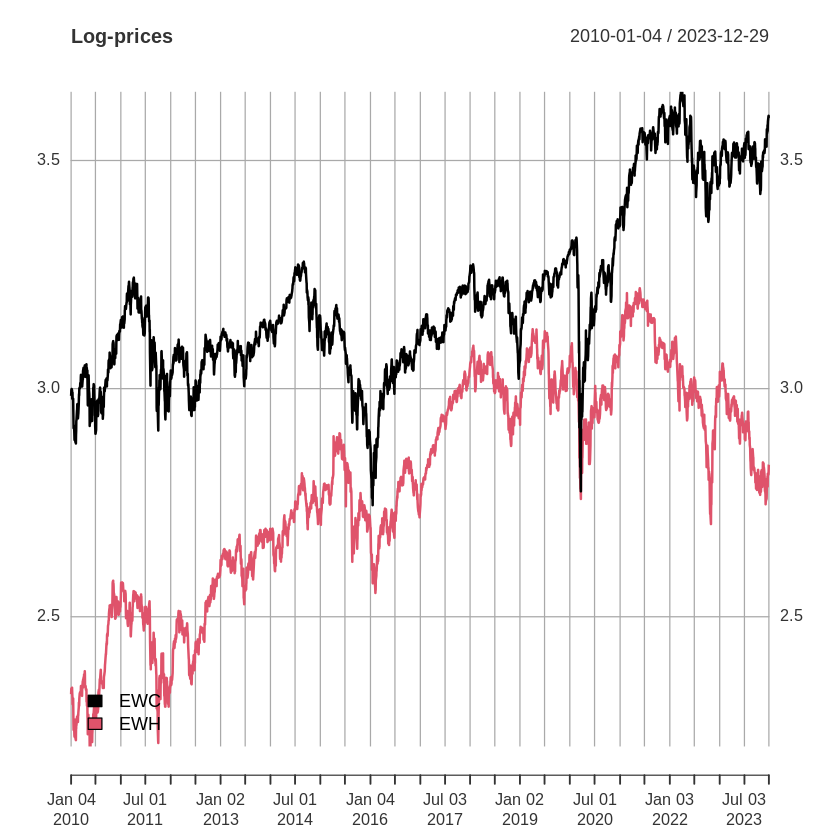

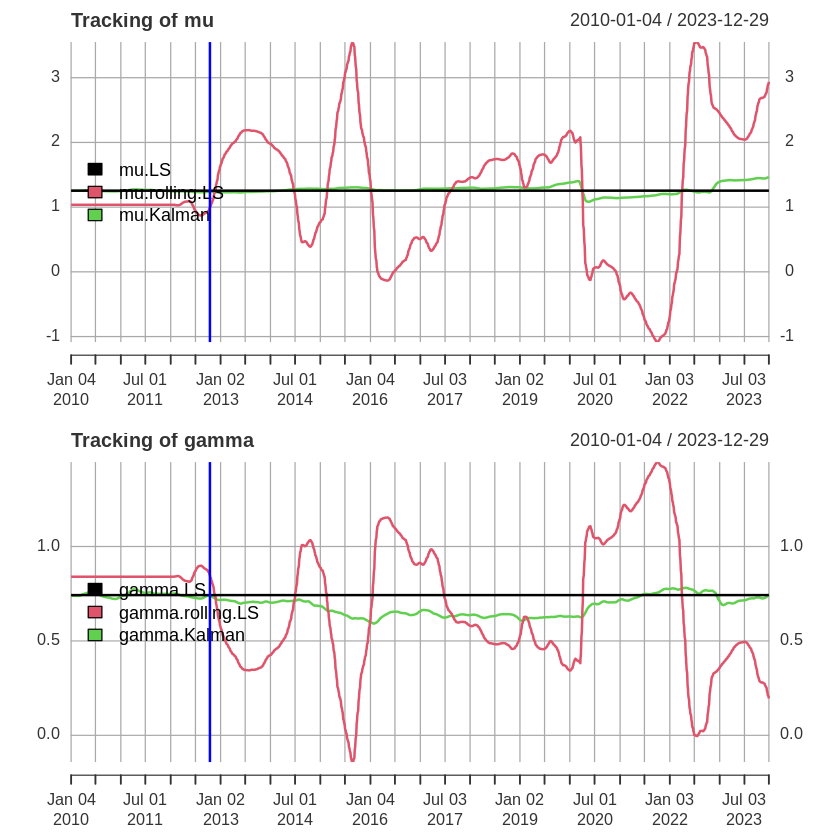

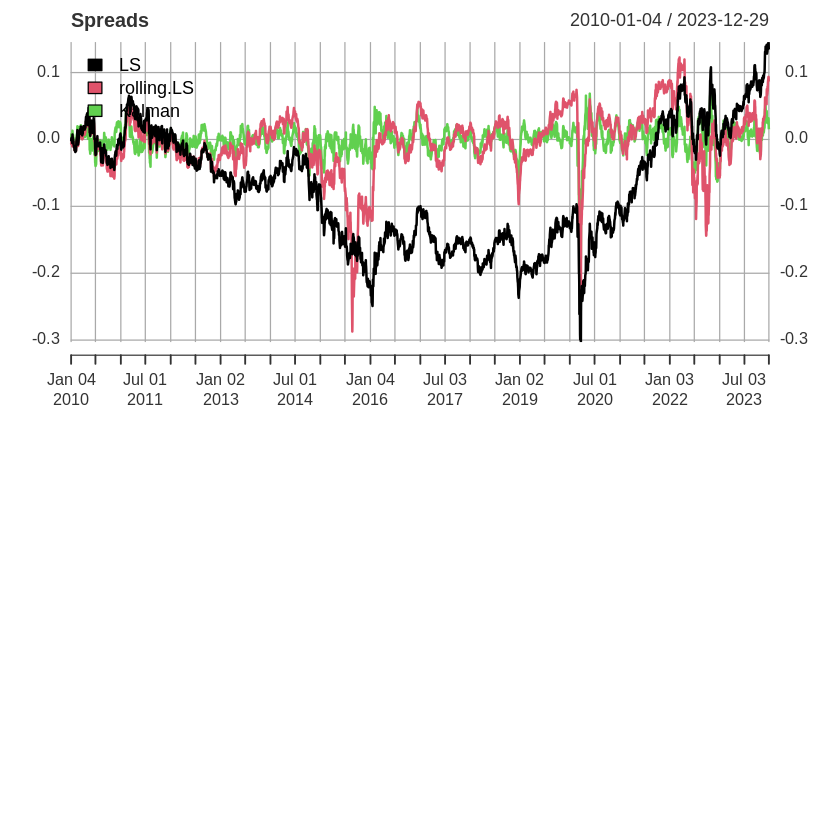

In [121]:
Y_ <- Y["2010-01::2023-12", c("EWC", "EWH")]
if(anyNA(Y_))
  Y_ <- na.approx(Y_)
plot(Y_, legend.loc = "bottomleft", main = "Log-prices")

LS <- estimate_mu_gamma_LS(Y_)
rolling_LS <- estimate_mu_gamma_rolling_LS(Y_)
Kalman <- estimate_mu_gamma_Kalman(Y_)

# plots
par(mfrow = c(2, 1))
{ plot(cbind(LS$mu, rolling_LS$mu, Kalman$mu),
       legend.loc = "left", main = "Tracking of mu")
  addEventLines(xts("", index(Y_[round(0.2*nrow(Y_))])), lwd = 2, col = "blue") }
{ plot(cbind(LS$gamma, rolling_LS$gamma, Kalman$gamma),
       legend.loc = "left", main = "Tracking of gamma")
  addEventLines(xts("", index(Y_[round(0.2*nrow(Y_))])), lwd = 2, col = "blue") }
compute_spread <- function(Y, gamma, mu, name = NULL) {
  w_spread <- cbind(1, -gamma)/cbind(1+gamma, 1+gamma)
  spread <- rowSums(Y * w_spread) - mu/(1+gamma)
  colnames(spread) <- name
  return(spread)
}


spread_LS <- compute_spread(Y_, LS$gamma, LS$mu, "LS")
spread_rolling_LS <- compute_spread(Y_, rolling_LS$gamma, rolling_LS$mu, "rolling-LS")
spread_Kalman <- compute_spread(Y_, Kalman$gamma, Kalman$mu, "Kalman")

# plots
plot(cbind(spread_LS, spread_rolling_LS, spread_Kalman), legend.loc = "topleft", main = "Spreads")

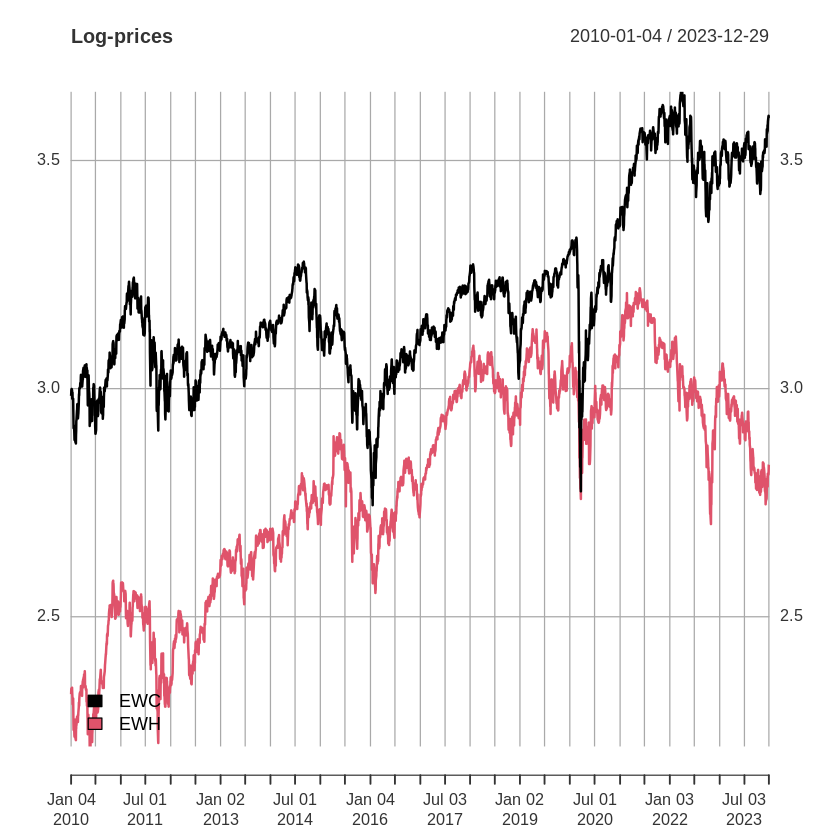

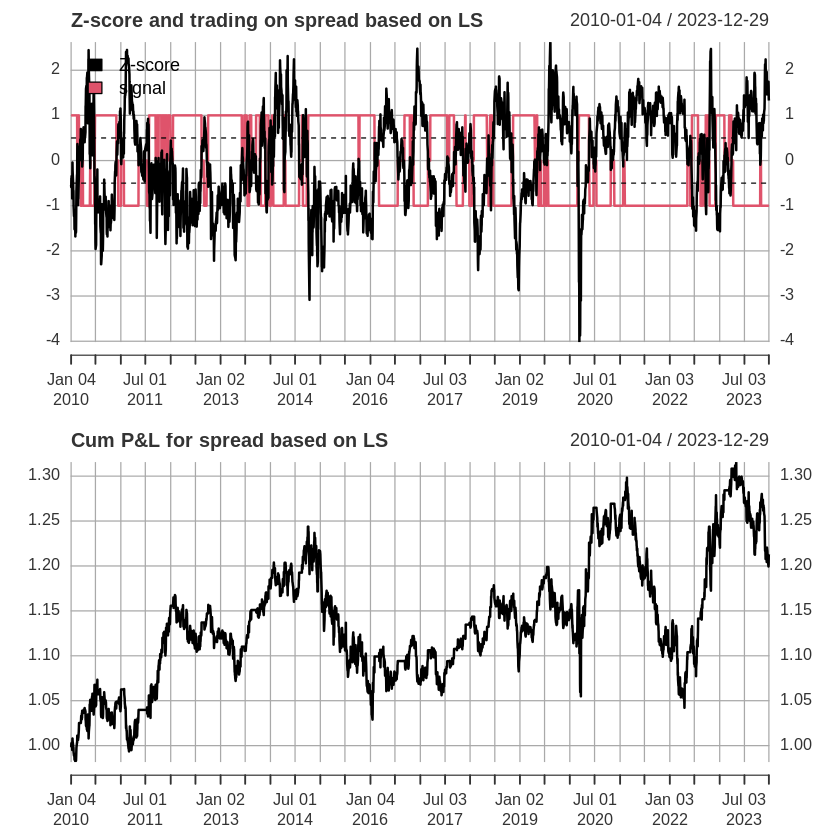

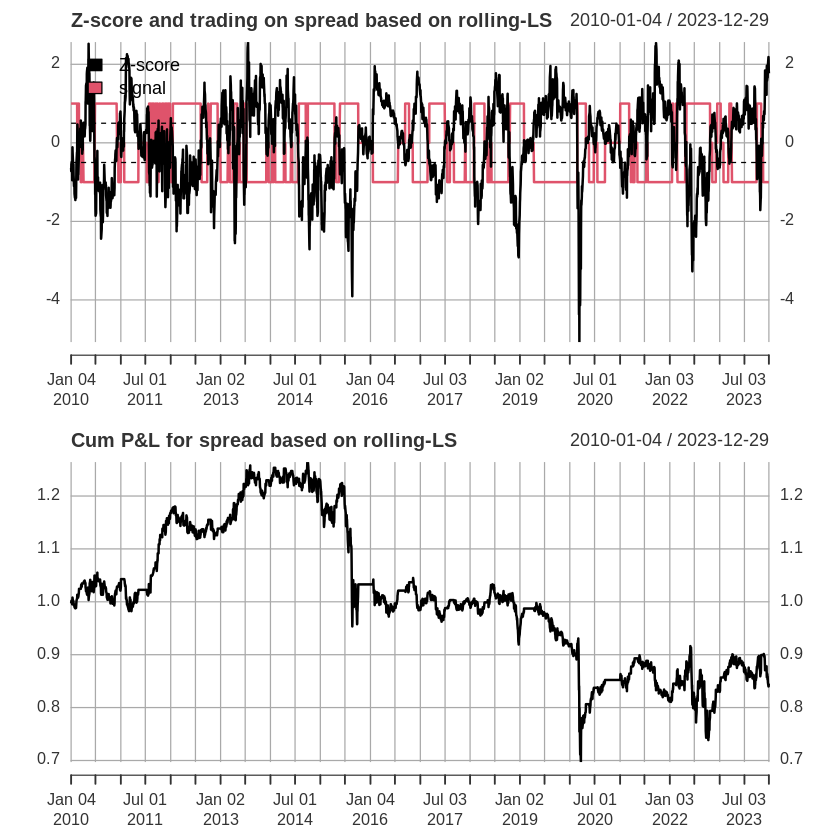

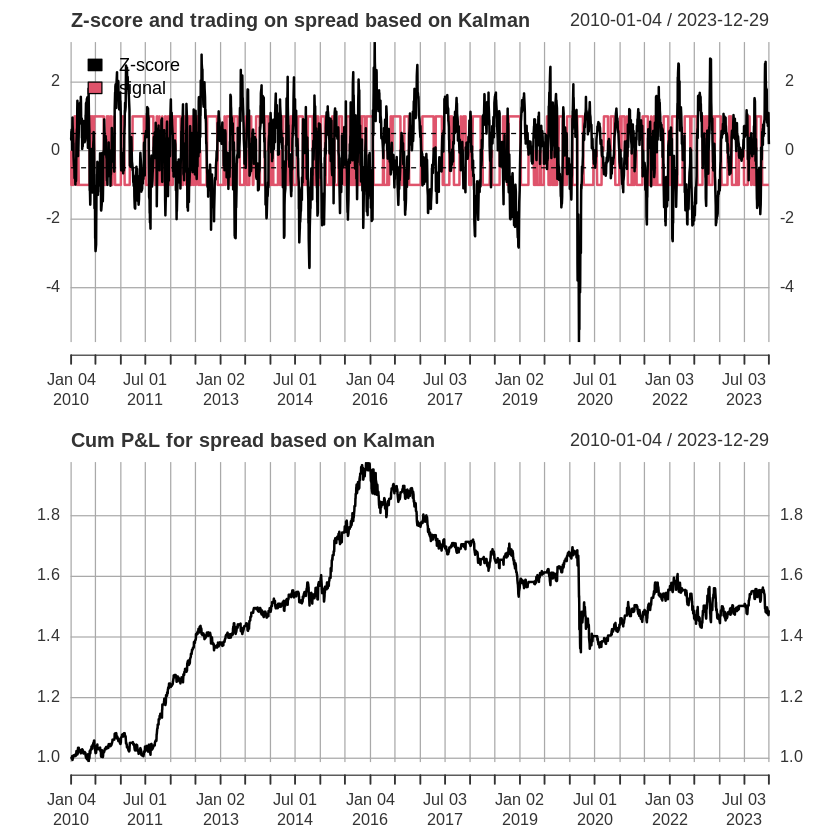

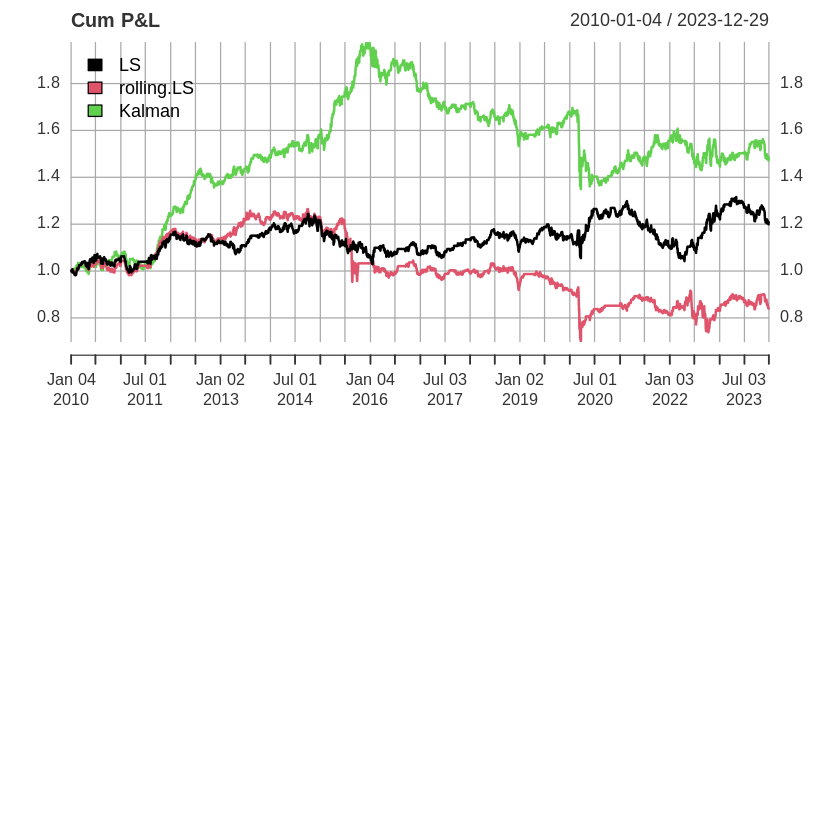

In [122]:
Y_ <- Y["2010-01::2023-12", c("EWC", "EWH")]
if(anyNA(Y_))
  Y_ <- na.approx(Y_)
plot(Y_, legend.loc = "bottomleft", main = "Log-prices")
return_LS <- pairs_trading(Y_["::2023-12"], LS$gamma["::2023-12"], LS$mu["::2023-12"],
                           "LS", plot = TRUE)
return_rolling_LS <- pairs_trading(Y_["::2023-12"], rolling_LS$gamma["::2023-12"], rolling_LS$mu["::2023-12"],
                                   "rolling-LS", plot = TRUE)
return_Kalman <- pairs_trading(Y_["::2023-12"], Kalman$gamma["::2023-12"], Kalman$mu["::2023-12"],
                               "Kalman", plot = TRUE)
                               # plot
plot(cumprod(1 + cbind(return_LS, return_rolling_LS, return_Kalman)["::2023-12"]),
     main = "Cum P&L", legend.loc = "topleft")

In [123]:
# Calculate performance for each strategy
performance_LS <- calculate_performance(return_LS)
performance_rolling_LS <- calculate_performance(return_rolling_LS)
performance_Kalman <- calculate_performance(return_Kalman)

# Print results
cat("Performance for LS strategy:\n")
cat("Overall Return: ", performance_LS$total_return, "\n")
cat("Annualized Return: ", performance_LS$annualized_return, "\n")
cat("Sharpe Ratio: ", performance_LS$sharpe_ratio, "\n")
cat("Number of Days: ", performance_LS$num_days, "\n\n")

cat("Performance for rolling LS strategy:\n")
cat("Overall Return: ", performance_rolling_LS$total_return, "\n")
cat("Annualized Return: ", performance_rolling_LS$annualized_return, "\n")
cat("Sharpe Ratio: ", performance_rolling_LS$sharpe_ratio, "\n")
cat("Number of Days: ", performance_rolling_LS$num_days, "\n\n")

cat("Performance for Kalman strategy:\n")
cat("Overall Return: ", performance_Kalman$total_return, "\n")
cat("Annualized Return: ", performance_Kalman$annualized_return, "\n")
cat("Sharpe Ratio: ", performance_Kalman$sharpe_ratio, "\n")
cat("Number of Days: ", performance_Kalman$num_days, "\n")

Performance for LS strategy:
Overall Return:  0.2129724 
Annualized Return:  1.01391 
Sharpe Ratio:  0.2122332 
Number of Days:  3522 

Performance for rolling LS strategy:
Overall Return:  -0.1542337 
Annualized Return:  0.988086 
Sharpe Ratio:  -0.06760931 
Number of Days:  3522 

Performance for Kalman strategy:
Overall Return:  0.4886517 
Annualized Return:  1.028877 
Sharpe Ratio:  0.3875045 
Number of Days:  3522 


Analyzing pair: EWA and EWC 
Analyzing pair: EWC and EWH 
Analyzing pair: EWS and EWH 
Overall Portfolio Performance (LS Strategy):
  Overall Return:  0.1900315 
  Annualized Return:  1.091264 
  Sharpe Ratio:  0.9888189 
  Number of Days:  502 

Overall Portfolio Performance (Rolling LS Strategy):
  Overall Return:  0.1269038 
  Annualized Return:  1.06181 
  Sharpe Ratio:  1.339124 
  Number of Days:  502 
Overall Portfolio Performance (Kalman Filter Strategy):
  Overall Return:  0.2662671 
  Annualized Return:  1.125815 
  Sharpe Ratio:  1.507568 
  Number of Days:  502 



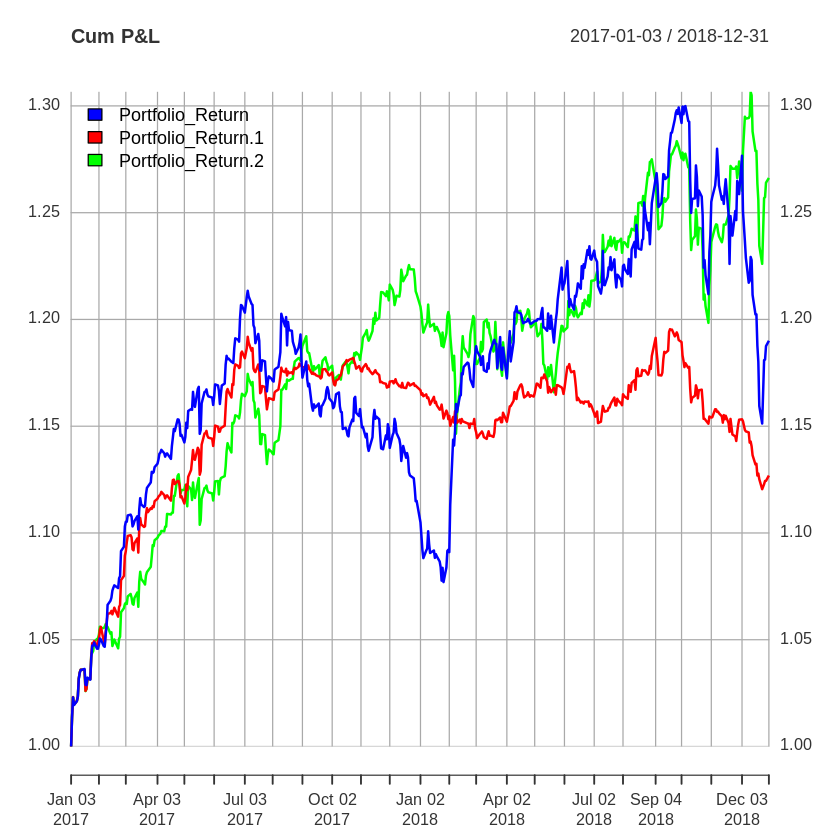

In [130]:

# Define the pairs of stocks to analyze
pairs <- list(
  c("EWA", "EWC"),
  c("EWC", "EWH"),
  c("EWS", "EWH")
)

# Initialize lists to store portfolio returns for each strategy
kalman_returns <- list()
ls_returns <- list()
rolling_ls_returns <- list()

# Function to perform analysis on a pair and return strategy-specific returns
analyze_pair <- function(Y, stock1, stock2, start_date, end_date) {
  # Subset data for the chosen pair
  Y_pair <- Y[paste0(start_date, "::", end_date), c(stock1, stock2)]
  if (anyNA(Y_pair)) Y_pair <- na.approx(Y_pair)

  # Run the analysis using the defined functions
  LS <- estimate_mu_gamma_LS(Y_pair)
  rolling_LS <- estimate_mu_gamma_rolling_LS(Y_pair)
  Kalman <- estimate_mu_gamma_Kalman(Y_pair)

  return_LS <- pairs_trading(Y_pair, LS$gamma, LS$mu, "LS", plot = FALSE)
  return_rolling_LS <- pairs_trading(Y_pair, rolling_LS$gamma, rolling_LS$mu, "rolling-LS", plot = FALSE)
  return_Kalman <- pairs_trading(Y_pair, Kalman$gamma, Kalman$mu, "Kalman", plot = FALSE)

  # Return returns for each strategy
  return(list(
    return_LS = return_LS,
    return_rolling_LS = return_rolling_LS,
    return_Kalman = return_Kalman
  ))
}

# Analyze each pair and store returns
for (pair in pairs) {
  stock1 <- pair[1]
  stock2 <- pair[2]

  cat("Analyzing pair:", stock1, "and", stock2, "\n")

  result <- analyze_pair(Y, stock1, stock2, "2017-01-01", "2018-12-31")

  kalman_returns[[paste(stock1, stock2, sep = "_")]] <- result$return_Kalman
  ls_returns[[paste(stock1, stock2, sep = "_")]] <- result$return_LS
  rolling_ls_returns[[paste(stock1, stock2, sep = "_")]] <- result$return_rolling_LS
}

# Combine returns for each strategy
combine_returns <- function(returns_list) {
  combined_returns <- NULL
  for (pair_name in names(returns_list)) {
    if (is.null(combined_returns)) {
      combined_returns <- returns_list[[pair_name]]
    } else {
      combined_returns <- merge(combined_returns, returns_list[[pair_name]])
    }
  }
  # Equally weight the returns
  portfolio_returns <- rowMeans(combined_returns, na.rm = TRUE)
  portfolio_returns <- xts(portfolio_returns, order.by = index(combined_returns))
  colnames(portfolio_returns) <- "Portfolio_Return"
  return(portfolio_returns)
}

# Calculate portfolio returns for each strategy
portfolio_returns_kalman <- combine_returns(kalman_returns)
portfolio_returns_ls <- combine_returns(ls_returns)
portfolio_returns_rolling_ls <- combine_returns(rolling_ls_returns)

# Calculate overall performance for each strategy
overall_performance_kalman <- calculate_performance(portfolio_returns_kalman)
overall_performance_ls <- calculate_performance(portfolio_returns_ls)
overall_performance_rolling_ls <- calculate_performance(portfolio_returns_rolling_ls)

# Print overall portfolio performance for each strategy
cat("Overall Portfolio Performance (LS Strategy):\n")
cat("  Overall Return: ", overall_performance_ls$total_return, "\n")
cat("  Annualized Return: ", overall_performance_ls$annualized_return, "\n")
cat("  Sharpe Ratio: ", overall_performance_ls$sharpe_ratio, "\n")
cat("  Number of Days: ", overall_performance_ls$num_days, "\n\n")

cat("Overall Portfolio Performance (Rolling LS Strategy):\n")
cat("  Overall Return: ", overall_performance_rolling_ls$total_return, "\n")
cat("  Annualized Return: ", overall_performance_rolling_ls$annualized_return, "\n")
cat("  Sharpe Ratio: ", overall_performance_rolling_ls$sharpe_ratio, "\n")
cat("  Number of Days: ", overall_performance_rolling_ls$num_days, "\n")

cat("Overall Portfolio Performance (Kalman Filter Strategy):\n")
cat("  Overall Return: ", overall_performance_kalman$total_return, "\n")
cat("  Annualized Return: ", overall_performance_kalman$annualized_return, "\n")
cat("  Sharpe Ratio: ", overall_performance_kalman$sharpe_ratio, "\n")
cat("  Number of Days: ", overall_performance_kalman$num_days, "\n\n")

# Plot cumulative returns for all strategies in one plot
combined_returns <- cbind(portfolio_returns_ls, portfolio_returns_rolling_ls, portfolio_returns_kalman)
combined_returns <- combined_returns["::2023-12"]

# Calculate cumulative returns
cum_returns <- cumprod(1 + combined_returns)

# Plot cumulative returns
plot(cum_returns, main = "Cum P&L", legend.loc = "topleft", col = c("blue", "red", "green"))

# Add legend
legend("topleft", legend = c("LS Strategy", "Rolling LS Strategy", "Kalman Filter Strategy"),
       col = c("blue", "red", "green"), lty = 1)